**# Integrantes**

- Alejandro Ruiz Luna
- Robinson Álvarez Patiño
- Ronald Ortíz García

In [2]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-01-FUNDAMENTOS/master/init.py
import init; init.init(force_download=False); 

# Precios de Casas

El objetivo de este taller es realizar un análisis exploratorio de un dataset. El dataset no llega limpio, el proceso de limpieza se encuentra implementado. Después de este proceso de limpieza se debe llevar a cabo el análisis exploratorio.

In [3]:
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Entendiendo y limpiando el dataset

In [4]:
!cat local/data/houseprices_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

La descripcion de cada variable puede verse ejecutando la siguiente celda

Ahora carguemos los datos y hagamos una breve exploración

In [5]:
df = pd.read_csv("local/data/houseprices.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Podemos ver que hay una gran cantidad de valores nulos en algunas de las variables. Alguien, algo despistado, podría sugerir simplemente eliminar esas variables; sin embargo, la descripción de las variables que observamos anteriormente, nos permite entender la razón de ser de estos valores nulos y tratarlos de una manera inteligente. Por ejemplo, consideremos la variable `PoolQC` la cual nos muestra únicamente 7 valores no nulos de los 1460 registros que tenemos en total. Su descripción dice:

```
PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

```

Esta variable hace referencia a la calidad de la piscina en la casa y vemos que `NA` significa que no tiene piscina, lo cual posiblemente tiene mucho impacto en el precio de una casa (pregúntese, ¿estaría dispuesto a pagar más por una casa que tenga piscina?). Además, vemos que existe la variable `PoolArea`, la cual almacena el area de la piscina en $ft^2$, la cual no tiene valores nulos. Dado esto, los valores nulos de la variable `PoolQC` deben corresponder a casos en los que la variable `PoolArea` es cero; validemos esto.

In [7]:
num_total_nulls = df["PoolQC"].isna().sum()
num_nulls_when_poolarea_is_zero = df[df["PoolArea"] == 0]["PoolQC"].isna().sum()
assert num_nulls_when_poolarea_is_zero == num_total_nulls

In [8]:
num_nulls_when_poolarea_is_not_zero = df[df["PoolArea"] != 0]["PoolQC"].isna().sum()
assert num_nulls_when_poolarea_is_not_zero == 0

Concluimos que se cumple que todos los valores nulos de la variable `PoolQC` corresponden a casos en los que no hay piscina; por lo tanto, vamos a reemplzar los valores nulos por otro valor que podamos usar en nuestros modelos.

In [9]:
df["PoolQC"] = df["PoolQC"].fillna("NP")

Esta misma lógica debemos usarla a la hora de tratar el resto de las variables con valores nulos de este dataset. Escribiremos algún razonamiento addiconal únicamente cuando haga falta

In [10]:
num_total_nulls = df["MiscFeature"].isna().sum()
num_nulls_when_miscval_is_zero = df[df["MiscVal"] == 0]["MiscFeature"].isna().sum()
num_nulls_when_miscval_is_not_zero = df[df["MiscVal"] != 0]["MiscFeature"].isna().sum()
assert num_nulls_when_miscval_is_zero == num_total_nulls
assert num_nulls_when_miscval_is_not_zero == 0
df["MiscFeature"] = df["MiscFeature"].fillna("No MF")

In [11]:
num_total_nulls = df["FireplaceQu"].isna().sum()
num_nulls_when_fireplaces_is_zero = df[df["Fireplaces"] == 0]["FireplaceQu"].isna().sum()
num_nulls_when_fireplaces_is_not_zero = df[df["Fireplaces"] != 0]["FireplaceQu"].isna().sum()
assert num_nulls_when_fireplaces_is_zero == num_total_nulls
assert num_nulls_when_fireplaces_is_not_zero == 0
df["FireplaceQu"] = df["FireplaceQu"].fillna("No FP")

In [12]:
num_area_zeros = (df["GarageArea"] == 0).sum()
num_cars_zeros = (df["GarageCars"] == 0).sum()
num_both_zeros = ((df["GarageArea"] == 0) & (df["GarageCars"] == 0.0)).sum()
assert num_both_zeros == num_area_zeros == num_cars_zeros
for colname in ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]:
    num_total_nulls = df[colname].isna().sum()
    num_nulls_when_area_and_cars_capacity_is_zero = df[(df["GarageArea"] == 0.0) & (df["GarageCars"] == 0.0)][colname].isna().sum()
    num_nulls_when_area_and_cars_capacity_is_not_zero = df[(df["GarageArea"] != 0.0) & (df["GarageCars"] != 0.0)][colname].isna().sum()
    assert num_total_nulls == num_nulls_when_area_and_cars_capacity_is_zero
    assert num_nulls_when_area_and_cars_capacity_is_not_zero == 0
    df[colname] = df[colname].fillna("No Ga")

Para la variable `GarageYrBlt` debemos ser más cuidadosos, ya que son números y no strings. Esta variable nos dice el año en que fue construido el garaje y, según lo visto con otras variables relacionadas al garage, los valores nulos corresponden a casos en los que no hay garage. En este caso, vamos a imputar esa variable con un año posterior a la fecha de venta. Esta aproximación podría no funcionar muy bien con modelos lineales, o cuando escalamos los datos, pero no se me ocurre otra!

In [13]:
num_total_nulls = df["GarageYrBlt"].isna().sum()
num_nulls_when_area_and_cars_is_zero = df[(df["GarageArea"] == 0.0) & (df["GarageCars"] == 0.0)]["GarageYrBlt"].isna().sum()
num_nulls_when_area_and_cars_is_not_zero = df[(df["GarageArea"] != 0.0) & (df["GarageCars"] != 0.0)]["GarageYrBlt"].isna().sum()
assert num_nulls_when_area_and_cars_is_zero == num_total_nulls
assert num_nulls_when_area_and_cars_is_not_zero == 0
df["GarageYrBlt"].where(~df["GarageYrBlt"].isna(), other=df["YrSold"] + 1, inplace=True)

`LotFrontage: Linear feet of street connected to property)`

Valores nulos en esta variable podrían ser ocasionados porque sencillamente no hay conexión de la calle a la propiedad, es decir, que esa longitud medida por esta variable es igual a 0. Podemos asumir que este es el caso únicamente si no hay otro 0 en los valores que ha tomado esta variable, de otra manera ¿por qué algunos tendrían 0 y otros nulos?

In [14]:
assert (df["LotFrontage"] == 0).sum() == 0
df["LotFrontage"].fillna(0, inplace=True)

In [15]:
df["Alley"].fillna("NA", inplace=True)
df["Fence"].fillna("NF", inplace=True)

```
MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
	
MasVnrArea: Masonry veneer area in square feet
```

Una posibilidad es que los valores nulos de `MasVnrType` y `MasVnrArea` correspondan a casos en los que no hay "Masonry veneer" (chapa de albañilería). Esto sería en los casos en que la variable `MasVnrArea` sea 0, esto lo validaremos de la misma manera en que validamos con la variable `LotFrontage`.

In [16]:
(df["MasVnrArea"] == 0).sum() == df["MasVnrType"].isnull().sum()

False

Acá la situación es diferente, el error anterior nos dice que los casos para los cuales no tenemos área son distintos de los que el tipo es nulo, entonces nos toca inspeccionar más en detalle. Sabemos que hay 8 valores nulos en cada una de las dos variables, miremos si corresponden a los mismos registros:

In [17]:
np.logical_and(df["MasVnrType"].isnull().values, df["MasVnrArea"].isnull().values).sum()

8

En efecto, dado que hay 8 registros para los cuales las dos variables tienen valores nulos, podemos decir que son nulos en ambas partes. A falta de información, vamos a decidir eliminar esos registros por completo, no debe ser muy grave, pues apenas son 8 filas en todo el dataset.

In [18]:
df = df.dropna(subset=["MasVnrType", "MasVnrArea"])

Ahora miremos los valores de cada una

In [19]:
df["MasVnrType"].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [20]:
df["MasVnrArea"].value_counts()

0.0      861
180.0      8
72.0       8
108.0      8
120.0      7
        ... 
562.0      1
89.0       1
921.0      1
762.0      1
119.0      1
Name: MasVnrArea, Length: 327, dtype: int64

Acá podemos observar lo siguiente:
- Hay 864 registros con `MasVnrType="None"`
- Hay 861 registros con `MasVnrArea=0`

Eso quiere decir que hay algunos registros que deberían tener un área de 0 y no es así. Vamos a mirar en detalle cuáles son:

In [21]:
df[(df["MasVnrType"] == "None") & (df["MasVnrArea"] != 0.0)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
624,625,60,RL,80.0,10400,Pave,NA,Reg,Lvl,AllPub,...,0,NP,NF,No MF,0,11,2006,WD,Normal,165150
773,774,20,RL,70.0,10150,Pave,NA,Reg,Lvl,AllPub,...,0,NP,NF,No MF,0,7,2007,COD,Normal,114500
1230,1231,90,RL,0.0,18890,Pave,NA,IR1,Lvl,AllPub,...,0,NP,NF,Gar2,8300,8,2007,WD,Normal,190000
1300,1301,60,RL,0.0,10762,Pave,NA,IR1,Lvl,AllPub,...,0,NP,NF,No MF,0,5,2009,WD,Normal,225000
1334,1335,160,RM,24.0,2368,Pave,NA,Reg,Lvl,AllPub,...,0,NP,NF,No MF,0,5,2009,WD,Normal,125000


**Francamente** yo no soy un experto en casas, por lo que no tengo forma de deducir a qué se debe esa incoherencia en los datos. Por lo anterior, simplemente voy a eliminar esas filas, ya que tengo dudas de la veracidad de esos datos.

In [22]:
df = df[~((df["MasVnrType"] == "None") & (df["MasVnrArea"] != 0.0))]

La variable `Electrical` tampoco nos ofrece una forma de recuperar esos valores nulos, por lo que también vamos a eliminar ese registro. Nótese que otra opción podría ser reemplazarlo con el valor más común en la misma variable, dado que esta es categórica. 

In [23]:
df.dropna(subset=["Electrical"], inplace=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1446 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1446 non-null   int64  
 1   MSSubClass     1446 non-null   int64  
 2   MSZoning       1446 non-null   object 
 3   LotFrontage    1446 non-null   float64
 4   LotArea        1446 non-null   int64  
 5   Street         1446 non-null   object 
 6   Alley          1446 non-null   object 
 7   LotShape       1446 non-null   object 
 8   LandContour    1446 non-null   object 
 9   Utilities      1446 non-null   object 
 10  LotConfig      1446 non-null   object 
 11  LandSlope      1446 non-null   object 
 12  Neighborhood   1446 non-null   object 
 13  Condition1     1446 non-null   object 
 14  Condition2     1446 non-null   object 
 15  BldgType       1446 non-null   object 
 16  HouseStyle     1446 non-null   object 
 17  OverallQual    1446 non-null   int64  
 18  OverallC

Ahora miremos las variables relacionadas con el basement:

```

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

```

Dado que los valores nulos en varias de estas variables corresponden a `No Basement`, ahora miremos si los registros nulos en algunas corresponden a los registros nulos en todas. Primero, dado que ya hemos eliminado varios registros, vamos a ver cuántos valores nulos hay en esas variables.

In [25]:
colnames = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
    "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]
for c in colnames:
    print(f"{c} has {df[c].isnull().sum()} null values")

BsmtQual has 37 null values
BsmtCond has 37 null values
BsmtExposure has 38 null values
BsmtFinType1 has 37 null values
BsmtFinSF1 has 0 null values
BsmtFinType2 has 38 null values
BsmtFinSF2 has 0 null values
BsmtUnfSF has 0 null values
TotalBsmtSF has 0 null values


In [26]:
df["TotalBsmtSF"].value_counts()

0       37
864     35
672     17
912     14
1040    14
        ..
1581     1
707      1
611      1
1452     1
1542     1
Name: TotalBsmtSF, Length: 716, dtype: int64

Acá vemos que algunas tienen más variables nulas que otras, lo cual es confuso porque en cualquier caso los valores nulos deberían significar que no hay basement. En este caso vamos a reemplazar los valores en los que los valores nulos sean en todas las variables no numéricas pero los que sobren los eliminaremos.

In [27]:
colnames = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
cond = ~(df["BsmtQual"].isna() & df["BsmtCond"].isna() & df["BsmtExposure"].isna() & df["BsmtFinType1"].isna() & df["BsmtFinType2"].isna())
for c in colnames:
    df[c].where(cond, other="NB", inplace=True)

In [28]:
df.dropna(inplace=True)
print(f"Number of null values {df.isna().sum().sum()} in a dataframe of shape {df.shape}")

Number of null values 0 in a dataframe of shape (1444, 81)


## Análisis exploratorio de datos

En esta sección se dejarán preguntas que deben ser respondidas utilizando los datos.

**¿Qué tan viejas son las casas?**

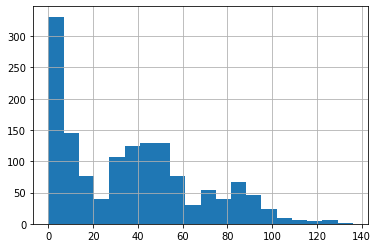

In [29]:
df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
df["HouseAge"].hist(bins=20)

**¿Cómo se relaciona el precio con la edad de la casa?**
Graficando  las dos variables en un Scatter podemos notar que existe una relacion inversa entre la edad de casa y el precio.  Entre mas reciente es la construccion mayor es el precio.

In [30]:
data = pd.concat([df["SalePrice"],df["HouseAge"]],axis=1)   # Reducimos el dataframe a las columnas precio y edad de la casa

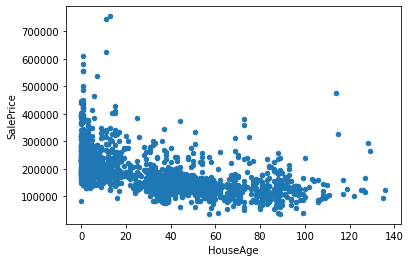

In [31]:
data.plot.scatter(x="HouseAge",y="SalePrice",ylim=(0.8000))   # Graficamos

Para entender porque la relacion entre precio y año no es "perfectamente" inversa, vamos graficar en un boxplot año a año con la dispersion del precio versus el año de construccion.

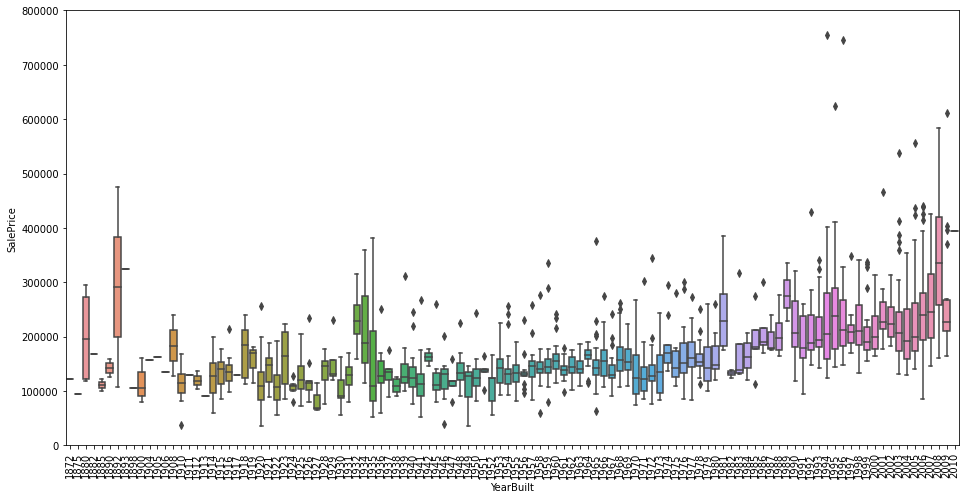

In [32]:
var = 'YearBuilt'
data = pd.concat([df['SalePrice'], df[var]], axis=1) #  Reducimos el dataframe a las columnas precio y edad de la casa
f, ax = plt.subplots(figsize=(16, 8))   #ajustamos el tamaño del grafico
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

Esta grafica nos muestra unos outlayer  que representan casas que a pesar de tener mucho tiempo de construccion, se han vendido por precios  muy altos, lo cual explica el porque no se ve una relacion perfectamente inversa en todos los casos.

**¿Cuál es el barrio más pobre?**


In [33]:
data = pd.concat([df["SalePrice"],df["Neighborhood"],df['Utilities'],df['MSZoning'],df["OverallCond"]],axis=1)
data.groupby(['Neighborhood']).size()

Neighborhood
Blmngtn     17
Blueste      2
BrDale      15
BrkSide     58
ClearCr     28
CollgCr    148
Crawfor     50
Edwards    100
Gilbert     77
IDOTRR      37
MeadowV     17
Mitchel     49
NAmes      224
NPkVill      9
NWAmes      72
NoRidge     41
NridgHt     75
OldTown    113
SWISU       25
Sawyer      73
SawyerW     58
Somerst     83
StoneBr     25
Timber      37
Veenker     11
dtype: int64

In [34]:
df["SalePrice"].describe()

count      1444.000000
mean     180602.092798
std       79414.474218
min       34900.000000
25%      129900.000000
50%      162000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Para identificar el barrio mas pobre iniciamos reduciendo nuestro dataframe a las variables que consideramos que se relacionan a la pobreza, para este caso serían "Utilities","SalePrice", "Neighborhood" y "OverallCond"

La variable "Utilities" Cateregoriza la cantidad de servicios que tiene una casa, por otro lado, "OverallCond" Califica el estado general de la casa, estos criterio sumados al precio de la casa, podria darnos información de cuales barrios son "pobres"

In [35]:
data = pd.concat([df["SalePrice"],df["Neighborhood"],df['Utilities'],df["OverallCond"]],axis=1)
data.groupby(['Utilities','Neighborhood']).mean().sort_values('Utilities',ascending = False).head(10)

SalePrice  OverallCond
Utilities Neighborhood                            
NoSeWa    Timber        137500.000000     6.000000
AllPub    Blueste       137500.000000     6.000000
          Veenker       238772.727273     6.272727
          Timber        247233.416667     5.111111
          StoneBr       310499.000000     5.000000
          Somerst       226443.566265     5.024096
          SawyerW       186584.344828     5.155172
          Sawyer        136064.273973     5.821918
          SWISU         142591.360000     5.920000
          OldTown       128225.300885     6.353982

Luego de aplicar los criterios para segmentar nuestro conjunto de datos,concluimos que el barrio mas pobre es **Timber** dado que la mayoria de las casa no tienen todos los servicios, el precio de las casas es mas bajo que el promedio y además el estado promedio de las casas esta deteriorado 

**¿Cuál es el barrio más cercano a vías férreas?**

In [36]:
df["Condition1"].describe()

count     1444
unique       9
top       Norm
freq      1246
Name: Condition1, dtype: object

Para identificar el barrio mas próximo a las vías férreas, iniciamos reduciendo nuestro dataframe a las variables que consideramos que se relacionan a la proximidad, para este caso serían "Condition1", "Condition2" y "Neighborhood"

Considerando que el criterio para determinar la proximidad a las vías ferreas son aquellos que cumplan con alguno/s de estos valores 'RRNn','RRAn','RRNe','RRAe', sabiendo esto, segmentamos los datos a los barrios que cumplan con estos valores

In [37]:
near_train = pd.concat([df["Id"],df["Neighborhood"],df['Condition1'],df['Condition2']],axis=1)
data = near_train [near_train.Condition1.isin(['RRNn','RRAn','RRNe','RRAe']) | near_train.Condition2.isin(['RRNn','RRAn','RRNe','RRAe'])]
data.groupby("Neighborhood").size()

Neighborhood
BrkSide    9
Gilbert    9
IDOTRR     2
NWAmes     7
OldTown    2
Sawyer     6
SawyerW    6
Somerst    6
dtype: int64

Notamos que para dos **BrkSide, Gilbert** barrios se cumplen que 9 de sus casas se encuentran proximas a las vías ferreas

**¿Cuál es la cobertura más común en las casas que se encuentran en el top 10% en precio?**

Para identificar cuales son las casas que se encuentran en el top 10% en precio creamos un nuevo DataFrame "top_10_percent" que contiene el 10% de la columna ordenada de "SalePrice". Luego de eso asociamos las variables de cobertura que para este caso son "Exterior1st" y "Exterior2nd".

Por ultimo hacemos el conteo de cada criterio de las variables anteriores

In [38]:
top_10_percent= df[df["SalePrice"].sort_values(ascending= False) > df.SalePrice.quantile(0.9)]
cobertur=top_10_percent[["Exterior1st","Exterior2nd"]].value_counts()
cobertur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Exterior1st  Exterior2nd
VinylSd      VinylSd        83
CemntBd      CmentBd        19
MetalSd      MetalSd         9
Wd Sdng      Wd Sdng         6
BrkFace      BrkFace         5
HdBoard      HdBoard         5
Plywood      Plywood         4
Wd Sdng      ImStucc         2
WdShing      Wd Shng         2
BrkFace      Wd Sdng         2
             HdBoard         1
Stucco       CmentBd         1
             Stucco          1
VinylSd      ImStucc         1
             Other           1
Plywood      Wd Sdng         1
CemntBd      Wd Shng         1
Stone        HdBoard         1
dtype: int64

Podemos notar que, para el top 10% de los precios de las casas, la cobertura mas común es la de ***VinylSd*** usada por 83 casas


**¿En qué barrio hay mayor desigualdad?**.  Vamos a considerar "desigualdad" como la diferencia en los precios de venta de las casa.  
- Vamos a filtrar Barrios por encima de 10 viviendas (con el objetivo de tomar barrios representativos) 
- Buscaremos la Desviacion estandar de sus precios como elemento para determinar la desigualdad. 

In [39]:
df_ori_rap = df.copy()  # copia del dataframe

In [40]:
group_x_neigh = df_ori_rap.groupby('Neighborhood').agg(np.count_nonzero) 


In [41]:
filtro_barrios_grandes = group_x_neigh['Id'] >= 10   # Filtro todos aquellos que no tengamos mas de 10 viviendas


In [42]:
std = df_ori_rap.groupby('Neighborhood').agg(np.std)    # saco la desviacion estandar de todos
std['SalePrice'].sort_values()

Neighborhood
NPkVill      9377.314529
BrDale      13710.708363
Blueste     19091.883092
Sawyer      21595.877724
MeadowV     23491.049610
Blmngtn     30393.229219
SWISU       32622.917679
NAmes       33082.594869
IDOTRR      33376.710117
Gilbert     36161.352410
Mitchel     36486.625334
NWAmes      37323.965554
BrkSide     40348.689270
Edwards     43208.616459
ClearCr     50231.538993
CollgCr     51649.462283
OldTown     52650.583185
SawyerW     56137.614907
Somerst     56874.974640
Timber      64516.423327
Crawfor     69550.599180
Veenker     72369.317959
NridgHt     96058.334691
StoneBr    112969.676640
NoRidge    121412.658640
Name: SalePrice, dtype: float64

In [43]:
std.loc[filtro_barrios_grandes, 'SalePrice'].max()   #aplico el fitro y selecciono el barrio que tiene la mas alta desviacion (NoRidge)


121412.65864036564

Para nosotros, teniendo en cuenta los barrios donde tenemos mas datos (mas de 10 ventas), el barrio que mas desigualdad presenta en funcion de la desviacion estandar de los precios de sus casas es:   **NoRidge** con una desviacion de US 121.412 en los precios de sus viviendas.

**¿En qué año hubo más movimiento del mercado inmobiliario?**

Para eso agrupamos todas las transacciones que se hayan hecho por cada año en el DataSet y luego lo ordenamos para encontrar el año con mayor moviemiento. La respuesta es :  **2009** con 334 ventas

In [44]:
resultado = df.groupby('YrSold').agg(np.count_nonzero).sort_values('Id', ascending=False)   # agrupacion por año
resultado = resultado.rename(columns={'Id':'Houses sold'})       # cambio nombre de columnas
resultado['Houses sold']

YrSold
2009    334
2007    325
2006    311
2008    300
2010    174
Name: Houses sold, dtype: int64

**¿Cuáles son los 2 barrios con mayor industria cerca?**

In [45]:
df["MSZoning"].value_counts()

RL         1139
RM          217
FV           62
RH           16
C (all)      10
Name: MSZoning, dtype: int64

Partiendo de la clasificación de la zona de venta, evidenciamos que no existe ninguna casa que cumpla con el criterio de "I" = Industrial, o casa dentro de una zona industrial. 

En vista de que no existe algún/a otra variable que de información acerca de si un barrio se encuentra cerca o no de una zona industrial. Concluimos que no hay ventas de casa en barrios cerca a zonas industriales.

**¿Cuáles son los 2 barrios con mayor comercio cerca?**
Vamos a considerar los barrios que se han vendido en zona comercial, para mirar esto tenemos en cuenta la variable MSZoning de cada barrio con el fin de encontrar aquellas ventas que se han realizado en barrios comerciales.

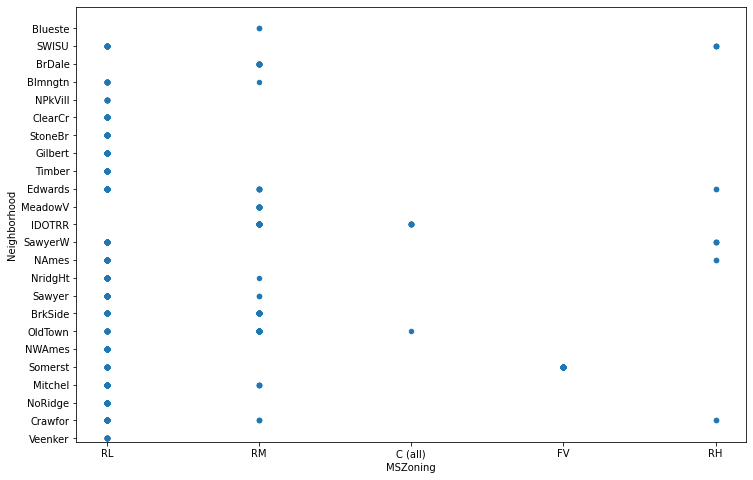

In [46]:
data2 = pd.concat([df["MSZoning"],df["Neighborhood"]],axis=1)
data2.plot.scatter(x="MSZoning",y="Neighborhood",ylim=(0.8000), figsize=(12, 8))  # utilizamos Scatter para identificar las viviendas que se han vendido en barrios comerciales --> C (all)


In [47]:
df_ori_rap = df[(df["MSZoning"] == "C (all)")]
df_ori_rap.Neighborhood   # Corroborando la informacion en el DataSet

30       IDOTRR
88       IDOTRR
93      OldTown
495      IDOTRR
557      IDOTRR
711      IDOTRR
812      IDOTRR
916      IDOTRR
1061     IDOTRR
1279     IDOTRR
Name: Neighborhood, dtype: object

Dado los resultados anteriores las casas que se han vendido en la zonas comerciales estan ubicadas en los barrios: **IDOTRR** (9 viviendas) Y **OldTown** (una sola vivienda)